In [1]:
import pandas as pd
import numpy as np
import os

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter

import pickle as pkl

import matplotlib.pyplot as plt

%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# load events, confounds, timeseries df
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/all_subjects_stn_timeseries.pkl')

events['onset'] -= 1.5  # STC

# Fit GLM with canonical HRF

### Following GdH's PhD thesis, we fit 4 different GLMs:
1. GLM1a: (a) neutral cue, (b) payoff cue, (c) easy stimulus, and (d) hard stimulus. Its first main contrast of interest was ‘payoff cue > neutral cue’, the other main contrast was ‘hard stimulus > easy stimulus’
2. GLM1b: (a) neutral cue, (b) payoff cue (left), (c) payoff cue (right), (d) easy stimulus, and (e) hard stimulus. The contrast of interest was “payoff cue (left) > payoff cue (right)”.
3. GLM 1c: (a) neutral cue, (b) payoff cue, (d) easy stimulus (correct), (e) easy stimulus (error), (f) hard stimulus (correct), and (g) hard stimulus (error). The main contrast: ‘hard stimulus (correct) > easy stimulus (correct)’
4. GLM 2: (a) neutral cue, (b) potential payoff cue, (c) easy trials, (d) hard trials, (e) left responses, and (f) right responses. Contrast: Lateralization.

# GLM 1a

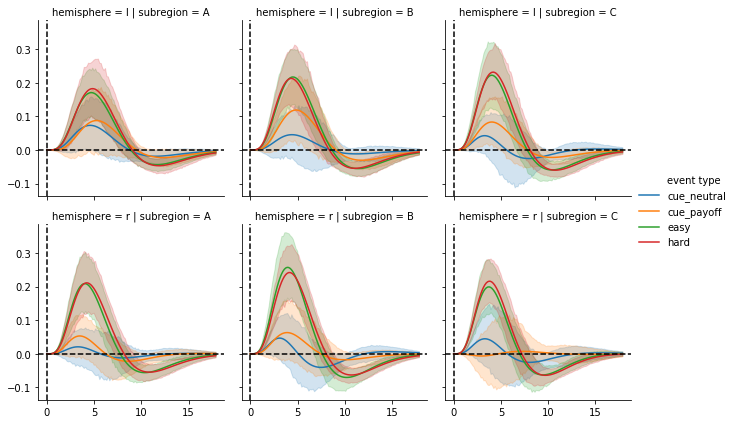

In [54]:
events_1a = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])]
events_1a.loc[events_1a['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm1a = GroupResponseFitter(df.copy(), 
                            events_1a, 
                            confounds=confounds,
                            input_sample_rate=1/3, 
                            oversample_design_matrix=20, 
                            concatenate_runs=True)
for event_type in events_1a.event_type.unique():
    glm1a.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm1a.fit()

# get timecourses
tc = glm1a.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

### Statistics

,mask,p,t,p.fdr
0,signal_l_A,0.572307,0.570524,0.686768
1,signal_l_B,0.042989,2.107619,0.128967
2,signal_l_C,0.032081,2.241181,0.128967
3,signal_r_A,0.380627,0.889021,0.570940
4,signal_r_B,0.140382,1.511865,0.280764
5,signal_r_C,0.782024,-0.279022,0.782024


,mask,p,t,p.fdr
0,signal_l_A,0.553772,-0.598420,0.830749
1,signal_l_B,0.716509,0.366359,0.830749
2,signal_l_C,0.602985,-0.525316,0.830749
3,signal_r_A,0.625843,-0.492335,0.830749
4,signal_r_B,0.830749,-0.215495,0.830749
5,signal_r_C,0.535315,-0.626680,0.830749


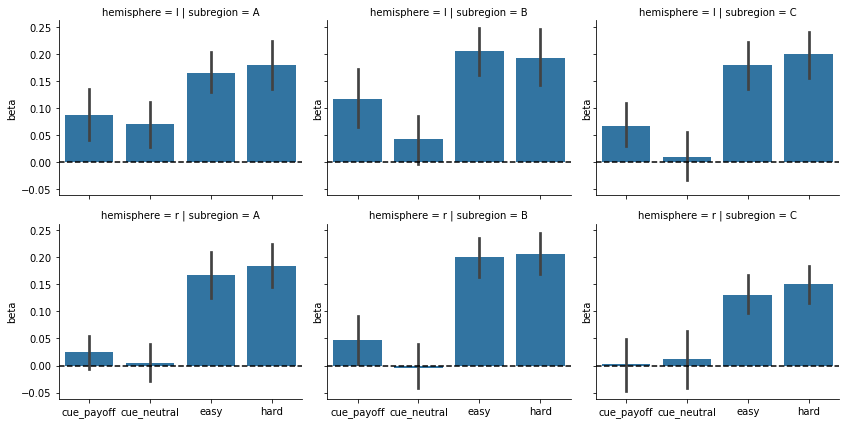

In [55]:
GLM1a_betas = pd.concat(glm1a.concat_response_fitters.apply(lambda x: x.betas).values)
GLM1a_betas = GLM1a_betas.loc[(('cue_payoff', 'cue_neutral', 'easy', 'hard'), 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM1a_betas['subject'] = np.repeat(np.arange(1, 34), 4)
GLM1a_betas = GLM1a_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM1a_betas_long = GLM1a_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM1a_betas_long['hemisphere'] = GLM1a_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1a_betas_long['subregion'] = GLM1a_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM1a_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_payoff', 'cue_neutral', 'easy', 'hard'], ci=67)#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--').set(ylabel='beta')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, two contrasts
results_cue = []
for roi in GLM1a_betas_long.roi.unique():
    deg_free = GLM1a_betas_long.loc[(GLM1a_betas_long['roi']==roi) & (GLM1a_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1a_betas_long.loc[(GLM1a_betas_long['roi']==roi) & (GLM1a_betas_long['event type'] == 'cue_payoff'), 'beta'],
                                       GLM1a_betas_long.loc[(GLM1a_betas_long['roi']==roi) & (GLM1a_betas_long['event type'] == 'cue_neutral'), 'beta'])
    results_cue.append({'mask': roi, 't': tval, 'p': pval})
results_cue = pd.DataFrame(results_cue)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_cue['p'], method='fdr_bh')
results_cue['p.fdr'] = p_fdr
display(results_cue)

results_difficulty = []
for roi in GLM1a_betas_long.roi.unique():
    tval, pval = scipy.stats.ttest_rel(GLM1a_betas_long.loc[(GLM1a_betas_long['roi']==roi) & (GLM1a_betas_long['event type'] == 'easy'), 'beta'],
                                       GLM1a_betas_long.loc[(GLM1a_betas_long['roi']==roi) & (GLM1a_betas_long['event type'] == 'hard'), 'beta'])
    results_difficulty.append({'mask': roi, 't': tval, 'p': pval})
results_difficulty = pd.DataFrame(results_difficulty)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_difficulty['p'], method='fdr_bh')
results_difficulty['p.fdr'] = p_fdr
display(results_difficulty)

In [58]:
GLM1a_betas_long.to_pickle('./derivatives/STN_GLM_betavalues.pkl')

In [56]:
GLM1a_betas_long1 = GLM1a_betas_long.loc[GLM1a_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1a_betas_long1 = GLM1a_betas_long1.rename(columns={'event type': 'event_type'})
GLM1a_betas_long1.head()

,subject,event_type,roi,beta,hemisphere,subregion
0,1,cue_payoff,signal_l_A,0.405325,l,A
3,1,cue_neutral,signal_l_A,0.256683,l,A
4,2,cue_payoff,signal_l_A,-0.228669,l,A
7,2,cue_neutral,signal_l_A,-0.173208,l,A
8,3,cue_payoff,signal_l_A,0.116644,l,A


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R -i GLM1a_betas_long1
library(BayesFactor)

b1 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'A','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'A','beta'], paired=TRUE)

b2 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'B','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'B','beta'], paired=TRUE)

b3 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'C','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'l' & GLM1a_betas_long1$subregion == 'C','beta'], paired=TRUE)

b4 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'A','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'A','beta'], paired=TRUE)
b5 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'B','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'B','beta'], paired=TRUE)
b6 = ttestBF(GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_payoff' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'C','beta'],
        GLM1a_betas_long1[GLM1a_betas_long1$event_type == 'cue_neutral' & GLM1a_betas_long1$hemisphere == 'r' & GLM1a_betas_long1$subregion == 'C','beta'], paired=TRUE)

print(paste0('BF01 for L A: ', extractBF(b1)$bf))  # substanial evidence against
print(paste0('BF01 for L B: ', extractBF(b2)$bf))  # anecdotal evidence for
print(paste0('BF01 for L C: ', extractBF(b3)$bf))  # anecdotal evidence for
print(paste0('BF01 for R A: ', extractBF(b4)$bf))  # substanial evidence against
print(paste0('BF01 for R B: ', extractBF(b5)$bf))  # anecdotal evidence against
print(paste0('BF01 for R C: ', extractBF(b6)$bf))  # substanial evidence against



Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



[1] "BF01 for L A: 0.216591246018336"
[1] "BF01 for L B: 1.30168179666648"
[1] "BF01 for L C: 1.64992522722311"
[1] "BF01 for R A: 0.268080725209154"
[1] "BF01 for R B: 0.522183919235035"
[1] "BF01 for R C: 0.193093923561417"


## Model building

Model beta values ~ event_type * hemipshere * subregion, and use model comparison to quantify evidence for/against specific independent variables

In [8]:
GLM1a_betas_long1 = GLM1a_betas_long1.loc[GLM1a_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1a_betas_long1 = GLM1a_betas_long1.rename(columns={'event type': 'event_type'})
GLM1a_betas_long1.head()

,subject,event_type,roi,beta,hemisphere,subregion
0,1,cue_payoff,signal_l_A,0.405325,l,A
3,1,cue_neutral,signal_l_A,0.256683,l,A
4,2,cue_payoff,signal_l_A,-0.228669,l,A
7,2,cue_neutral,signal_l_A,-0.173208,l,A
8,3,cue_payoff,signal_l_A,0.116644,l,A


In [18]:
%%R -i GLM1a_betas_long1
library(BayesFactor)

classifyEvidence <- function(bf) {
    if(bf < 1) {
        if(bf > (1/3.2)) return("Anecdotal evidence against H1")
        if(bf > (1/10)) return("Substantial evidence against H1")
        if(bf > (1/100)) return("Strong evidence against H1")
        return("Decisive evidence against H1")
    }
    if(bf > 1) {
        if(bf < (3.2)) return("Anecdotal evidence for H1")
        if(bf < (10)) return("Substantial evidence for H1")
        if(bf < (100)) return("Strong evidence for H1")
        return("Decisive evidence for H1")
    }
}

GLM1a_betas_long1$subject <- factor(GLM1a_betas_long1$subject)
GLM1a_betas_long1$event_type <- factor(GLM1a_betas_long1$event_type)
GLM1a_betas_long1$hemisphere <- factor(GLM1a_betas_long1$hemisphere)
GLM1a_betas_long1$subregion <- factor(GLM1a_betas_long1$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1a_betas_long1)
bf2 = lmBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1a_betas_long1)
bf3 = lmBF(beta ~ 1 + event_type+subregion, whichRandom="subject", data = GLM1a_betas_long1)
#bf3 = lmBF(beta ~ 1 + event_type*hemisphere, whichRandom="subject", data = GLM1a_betas_long1)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1a_betas_long1)
bf5 = lmBF(beta ~ 1 + hemisphere, whichRandom="subject", data = GLM1a_betas_long1)


print(paste0('BF01 for an effect of the event type [payoff/neutral]: ', round(extractBF(bf4)$bf, 3), ' (', classifyEvidence(extractBF(bf4)$bf), ')'))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', round(extractBF(bf3/bf4)$bf, 3), ' (', classifyEvidence(extractBF(bf3/bf4)$bf), ')'))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', round(extractBF(bf2/bf3)$bf, 3), ' (', classifyEvidence(extractBF(bf2/bf3)$bf), ')'))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', round(extractBF(bf1/bf4)$bf, 3), ' (', classifyEvidence(extractBF(bf1/bf4)$bf), ')'))

#print(paste0('BF01 for an effect of hemispheres: ', extractBF(bf5)$bf))

[1] "BF01 for an effect of the event type [payoff/neutral]: 0.266 (Substantial evidence against H1)"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.041 (Strong evidence against H1)"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.071 (Strong evidence against H1)"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 0 (Decisive evidence against H1)"


### In sum
- Substantial evidence against an effect of cue type 
- Inconclusive evidence against an effect of hemisphere
- Strong evidence against an effect of subregion

In [19]:
GLM1a_betas_long2 = GLM1a_betas_long.loc[GLM1a_betas_long['event type'].isin(['easy', 'hard'])]
GLM1a_betas_long2 = GLM1a_betas_long2.rename(columns={'event type': 'event_type'})

In [22]:
%%R -i GLM1a_betas_long2
library(BayesFactor)

GLM1a_betas_long2$event_type <- factor(GLM1a_betas_long2$event_type)
GLM1a_betas_long2$hemisphere <- factor(GLM1a_betas_long2$hemisphere)
GLM1a_betas_long2$subregion <- factor(GLM1a_betas_long2$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1a_betas_long2)
bf2 = lmBF(beta ~ 1 + event_type * subregion, whichRandom="subject", data = GLM1a_betas_long2)
bf3 = lmBF(beta ~ 1 + event_type + subregion, whichRandom="subject", data = GLM1a_betas_long2)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1a_betas_long2)

print(paste0('BF01 for an effect of the event type [easy/hard]: ', extractBF(bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf3/bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf2/bf3)$bf))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', extractBF(bf1/bf4)$bf))

[1] "BF01 for an effect of the event type [easy/hard]: 0.122649046343612"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0562854375227572"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0547624520592398"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 5.36856385160361e-07"


### In sum
- Substantial evidence against an effect of cue type 
- Substantial evidence against an effect of hemisphere
- Strong evidence against an effect of subregion

# GLM 1b

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


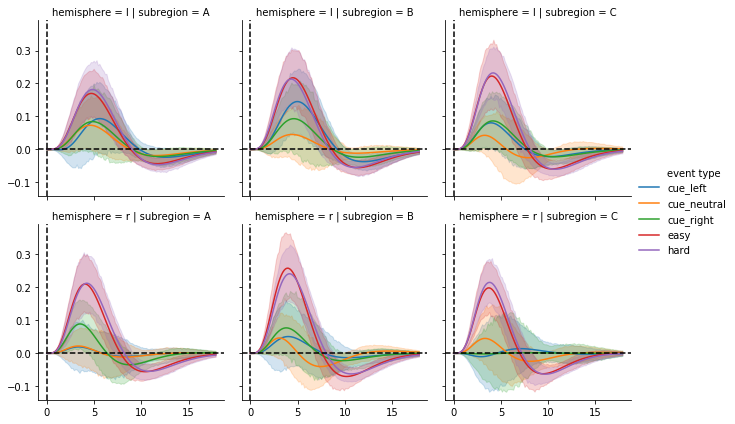

In [23]:
events_1b = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])].copy()

glm1b = GroupResponseFitter(df.copy(), 
                            events_1b, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_1b.event_type.unique():
    glm1b.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm1b.fit()

# get timecourses
tc = glm1b.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

### Statistics

,mask,p,t,p.fdr
0,signal_l_A,0.856795,0.181918,0.881666
1,signal_l_B,0.115007,1.620183,0.690045
2,signal_l_C,0.740199,-0.334481,0.881666
3,signal_r_A,0.340180,-0.968253,0.881666
4,signal_r_B,0.740559,-0.333999,0.881666
5,signal_r_C,0.881666,0.150052,0.881666


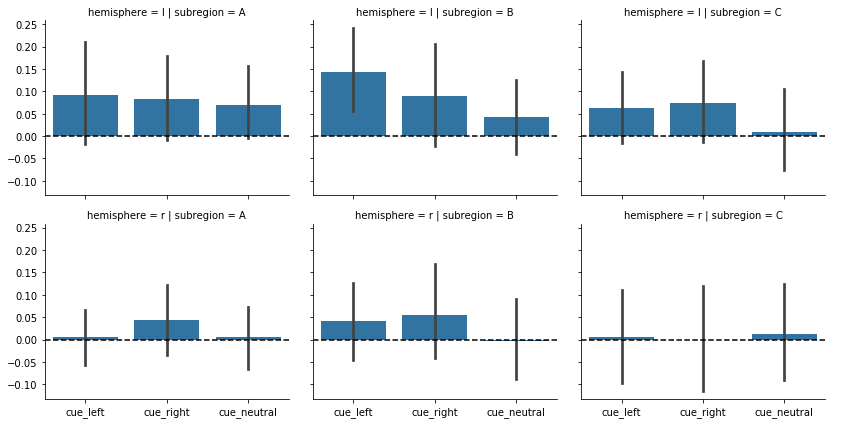

In [28]:
GLM1b_betas = pd.concat(glm1b.concat_response_fitters.apply(lambda x: x.betas).values)
GLM1b_betas = GLM1b_betas.loc[(('cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'), 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM1b_betas['subject'] = np.repeat(np.arange(1, 34), 5)
GLM1b_betas = GLM1b_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM1b_betas_long = GLM1b_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM1b_betas_long['hemisphere'] = GLM1b_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1b_betas_long['subregion'] = GLM1b_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM1b_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral'])#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM1b_betas_long.roi.unique():
    deg_free = GLM1b_betas_long.loc[(GLM1b_betas_long['roi']==roi) & (GLM1b_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1b_betas_long.loc[(GLM1b_betas_long['roi']==roi) & (GLM1b_betas_long['event type'] == 'cue_left'), 'beta'],
                                       GLM1b_betas_long.loc[(GLM1b_betas_long['roi']==roi) & (GLM1b_betas_long['event type'] == 'cue_right'), 'beta'])
    #print("Subregion {}, contrast cue_left != cue_right, t({}) = {:.4f}, p = {:.4f}".format(roi, deg_free, tval, pval))
    results.append({'mask': roi, 't': tval, 'p': pval})

results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
display(results)

In [29]:
GLM1b_betas_longR = GLM1b_betas_long.loc[GLM1b_betas_long['event type'].isin(['cue_left', 'cue_right'])]
GLM1b_betas_longR = GLM1b_betas_longR.rename(columns={'event type': 'event_type'})

In [30]:
%%R -i GLM1b_betas_longR
library(BayesFactor)

GLM1b_betas_longR$event_type <- factor(GLM1b_betas_longR$event_type)
GLM1b_betas_longR$hemisphere <- factor(GLM1b_betas_longR$hemisphere)
GLM1b_betas_longR$subregion <- factor(GLM1b_betas_longR$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1b_betas_longR)
bf2 = lmBF(beta ~ 1 + event_type + subregion, whichRandom="subject", data = GLM1b_betas_longR)
bf3 = lmBF(beta ~ 1 + event_type + hemisphere, whichRandom="subject", data = GLM1b_betas_longR)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1b_betas_longR)

print(paste0('BF01 for an effect of the event type [cue_left/cue_right]: ', extractBF(bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between hemispheres: ', extractBF(bf3/bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf2/bf4)$bf))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', extractBF(bf1/bf4)$bf))

[1] "BF01 for an effect of the event type [cue_left/cue_right]: 0.111322197289803"
[1] "BF01 for an additional effect of a difference in the effect of event type between hemispheres: 1.26842264930121"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0631879414556633"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 4.6519533631064e-06"


## In sum
- Substantial evidence against a difference in beta-values for cue_left and cue_right
- Inconclusive evidence for a difference between hemispheres
- Strong evidence against any difference in responses between subregions

# GLM1b conclusion: No differences in left/right cues in any subregion

# GLM1c

In [31]:
def combine_difficulty(x):
    x['next_event'] = x['event_type'].shift(-1)
    x['event_type'] = x['event_type'] + '_' + x['next_event']
    x = x.loc[x['event_type'].isin(['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])]
    return x[['onset', 'event_type', 'duration']]

tmp = events.copy().reset_index()
tmp = tmp.loc[tmp['event_type'].isin(['easy', 'hard', 'error', 'correct'])]
stim_diff = tmp.groupby(['subject', 'run']).apply(lambda x: combine_difficulty(x)).reset_index(level=2, drop=True)

tmp = events.copy()
tmp = tmp.loc[tmp['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_1c = pd.concat([tmp, stim_diff]).sort_values(['subject', 'run', 'onset'])

In [32]:
# def combine_difficulty_accuracy(x):
#     return '_'.join(x['event_type'].values)

# events_1c = events.copy().reset_index()
# events_1c = events_1c.loc[events_1c['event_type'].isin(['cue_payoff', 'easy', 'hard', 'cue_neutral', 'error', 'correct'])]
# events_1c = events_1c.groupby(['subject', 'run', 'onset']).apply(lambda x: combine_difficulty_accuracy(x)).reset_index().set_index(['subject', 'run'])
# events_1c = events_1c.rename(columns={0: 'event_type'})

# events_1c.loc[events_1c['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'
# events_1c = events_1c.loc[~events_1c['event_type'].isin(['response_left', 'response_right'])]
# events_1c.head()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nideconv/group_analysis.py:152: UserWarning: Event easy_error is not available for run (26, 2). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nideconv/group_analysis.py:152: UserWarning: Event easy_error is not available for run (27, 1). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nideconv/group_analysis.py:152: UserWarning: Event easy_error is not available for run (27, 2). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nideconv/group_analysis.py:152: UserWarning: Event easy_error is not available for run (27, 3). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nideconv/group_analysis.py:152: UserWarning: Event easy_error is not available for run (34, 1). Event is i

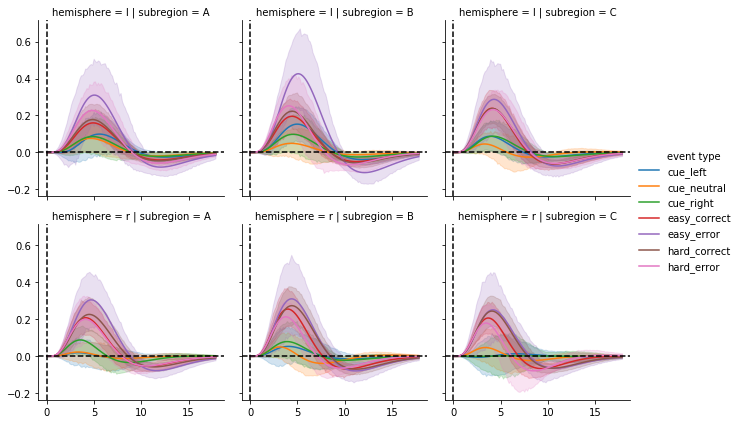

In [33]:
glm1c = GroupResponseFitter(df.copy(), 
                            events_1c, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_1c.event_type.unique():
    glm1c.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm1c.fit()

# get timecourses
tc = glm1c.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

In [34]:
def add_subject(x):
    betas = x.iloc[1].betas
    betas['subject'] = x.iloc[0]
    return betas

,mask,p,t,p.fdr
0,signal_l_A,0.519168,0.651826,0.623002
1,signal_l_B,0.498729,0.684273,0.623002
2,signal_l_C,0.924742,0.095209,0.924742
3,signal_r_A,0.333672,0.981576,0.623002
4,signal_r_B,0.188403,1.343991,0.565210
5,signal_r_C,0.085527,1.774311,0.513165


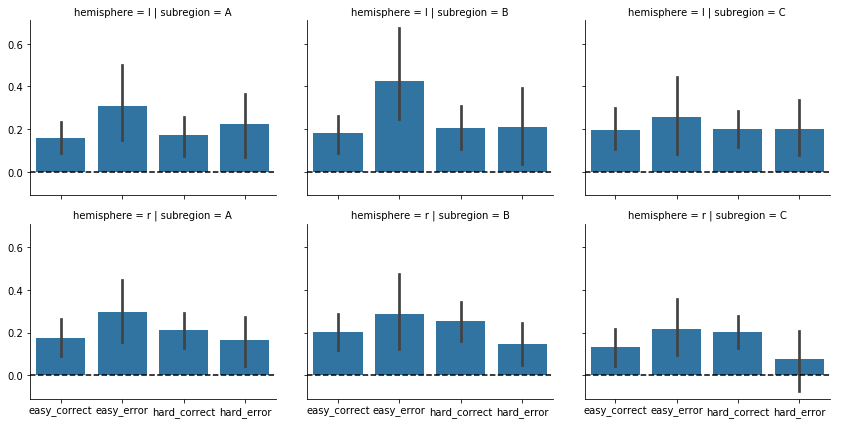

In [38]:
GLM1c_betas = pd.concat(glm1c.concat_response_fitters.reset_index().apply(lambda x: add_subject(x), axis=1).values)
GLM1c_betas = GLM1c_betas.loc[(('cue_payoff', 'cue_neutral', 'easy_correct', 'hard_correct', 'easy_error', 'hard_error'), 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM1c_betas = GLM1c_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM1c_betas_long = GLM1c_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM1c_betas_long['hemisphere'] = GLM1c_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1c_betas_long['subregion'] = GLM1c_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM1c_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM1c_betas_long.roi.unique():
    deg_free = GLM1c_betas_long.loc[(GLM1c_betas_long['roi']==roi) & (GLM1c_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1c_betas_long.loc[(GLM1c_betas_long['roi']==roi) & (GLM1c_betas_long['event type'] == 'hard_correct'), 'beta'],
                                       GLM1c_betas_long.loc[(GLM1c_betas_long['roi']==roi) & (GLM1c_betas_long['event type'] == 'easy_correct'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
display(results)

In [36]:
GLM1c_betas_longR = GLM1c_betas_long.loc[GLM1c_betas_long['event type'].isin(['hard_correct', 'easy_correct'])]
GLM1c_betas_longR = GLM1c_betas_longR.rename(columns={'event type': 'event_type'})

In [40]:
%%R -i GLM1c_betas_longR
library(BayesFactor)

GLM1c_betas_longR$event_type <- factor(GLM1c_betas_longR$event_type)
GLM1c_betas_longR$hemisphere <- factor(GLM1c_betas_longR$hemisphere)
GLM1c_betas_longR$subregion <- factor(GLM1c_betas_longR$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1c_betas_longR)
bf2 = lmBF(beta ~ 1 + event_type + subregion*event_type, whichRandom="subject", data = GLM1c_betas_longR)
bf3 = lmBF(beta ~ 1 + event_type + subregion, whichRandom="subject", data = GLM1c_betas_longR)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1c_betas_longR)

print(paste0('BF01 for an effect of the event type [hard_correct/easy_correct]: ', extractBF(bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between hemispheres: ', extractBF(bf3/bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf2/bf3)$bf))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', extractBF(bf1/bf4)$bf))

[1] "BF01 for an effect of the event type [hard_correct/easy_correct]: 0.259257276827313"
[1] "BF01 for an additional effect of a difference in the effect of event type between hemispheres: 0.0450449923339824"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.053633279259489"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 7.0779237348023e-07"


## In sum

- Substantial evidence against a difference in beta-values for easy_correct and hard_correct
- Substantial evidence against a difference between hemispheres
- Strong evidence against any difference in responses between subregions

In [41]:
GLM1c_betas_longR2 = GLM1c_betas_long.loc[GLM1c_betas_long['event type'].isin(['hard_error', 'easy_error'])]
GLM1c_betas_longR2 = GLM1c_betas_longR2.rename(columns={'event type': 'event_type'})

In [42]:
%%R -i GLM1c_betas_longR2
library(BayesFactor)

GLM1c_betas_longR2$event_type <- factor(GLM1c_betas_longR2$event_type)
GLM1c_betas_longR2$hemisphere <- factor(GLM1c_betas_longR2$hemisphere)
GLM1c_betas_longR2$subregion <- factor(GLM1c_betas_longR2$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1c_betas_longR2)
bf2 = lmBF(beta ~ 1 + event_type + subregion, whichRandom="subject", data = GLM1c_betas_longR2)
bf3 = lmBF(beta ~ 1 + event_type + hemisphere, whichRandom="subject", data = GLM1c_betas_longR2)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1c_betas_longR2)

print(paste0('BF01 for an effect of the event type [easy_error/hard_error]: ', extractBF(bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between hemispheres: ', extractBF(bf3/bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf2/bf4)$bf))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', extractBF(bf1/bf4)$bf))

[1] "BF01 for an effect of the event type [easy_error/hard_error]: 4.66932995159991"
[1] "BF01 for an additional effect of a difference in the effect of event type between hemispheres: 0.409922984436499"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0747496753039231"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 2.10371309213782e-06"


## In sum

- Substantial evidence for a difference in beta-values for easy_error and hard_error - increased error processing? (error is less expected)
- Substantial evidence against a difference between hemispheres
- Strong evidence against any difference in responses between subregions

# GLM2

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


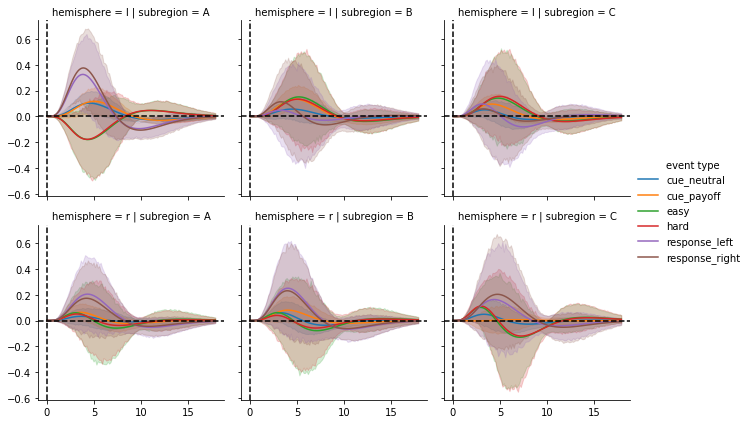

In [43]:
events_1d = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral', 'response_left', 'response_right'])]
events_1d.loc[events_1d['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm1d = GroupResponseFitter(df.copy(), 
                            events_1d, 
                            confounds=confounds,
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_1d.event_type.unique():
    glm1d.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm1d.fit()

# get timecourses
tc = glm1d.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')
fac.add_legend()

,mask,p,t,p.fdr
0,signal_l_A,0.190043,-1.338884,0.380085
1,signal_l_B,0.592013,-0.541354,0.657797
2,signal_l_C,0.657797,-0.447124,0.657797
3,signal_r_A,0.186429,1.350186,0.380085
4,signal_r_B,0.607340,0.518987,0.657797
5,signal_r_C,0.133421,-1.539881,0.380085


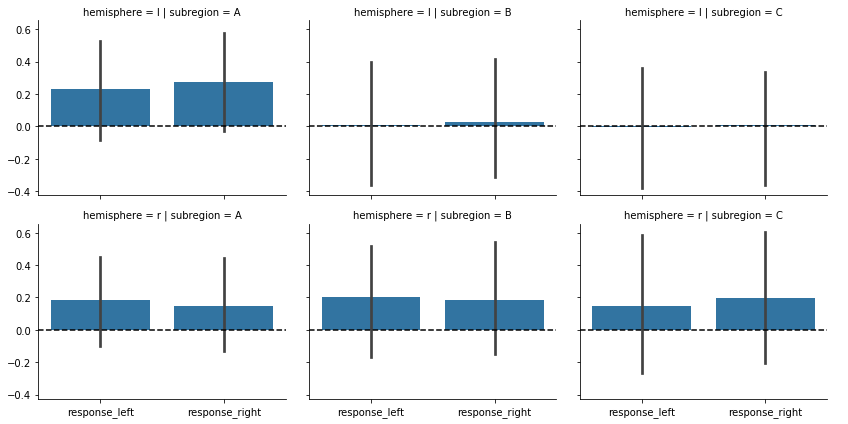

In [47]:
GLM1d_betas = pd.concat(glm1d.concat_response_fitters.reset_index().apply(lambda x: add_subject(x), axis=1).values)
GLM1d_betas = GLM1d_betas.loc[(('response_left', 'response_right'), 'intercept', 'HRF')].reset_index(level=[1,2], drop=True)
GLM1d_betas = GLM1d_betas.reset_index().set_index(['subject', 'event type'])

## long format for plotting
GLM1d_betas_long = GLM1d_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='roi', value_name='beta')
GLM1d_betas_long['hemisphere'] = GLM1d_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1d_betas_long['subregion'] = GLM1d_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM1d_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['response_left', 'response_right'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM1d_betas_long.roi.unique():
    deg_free = GLM1d_betas_long.loc[(GLM1d_betas_long['roi']==roi) & (GLM1d_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1d_betas_long.loc[(GLM1d_betas_long['roi']==roi) & (GLM1d_betas_long['event type'] == 'response_left'), 'beta'],
                                       GLM1d_betas_long.loc[(GLM1d_betas_long['roi']==roi) & (GLM1d_betas_long['event type'] == 'response_right'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
display(results)

In [48]:
GLM1d_betas_longR = GLM1d_betas_long.loc[GLM1d_betas_long['event type'].isin(['response_left', 'response_right'])]
GLM1d_betas_longR = GLM1d_betas_longR.rename(columns={'event type': 'event_type'})

In [53]:
%%R -i GLM1d_betas_longR
library(BayesFactor)

GLM1d_betas_longR$event_type <- factor(GLM1d_betas_longR$event_type)
GLM1d_betas_longR$hemisphere <- factor(GLM1d_betas_longR$hemisphere)
GLM1d_betas_longR$subregion <- factor(GLM1d_betas_longR$subregion)

bf1 = lmBF(beta ~ 1 + event_type*hemisphere*subregion, whichRandom="subject", data = GLM1d_betas_longR)
bf2 = lmBF(beta ~ 1 + event_type + subregion*event_type, whichRandom="subject", data = GLM1d_betas_longR)
bf3 = lmBF(beta ~ 1 + event_type + subregion, whichRandom="subject", data = GLM1d_betas_longR)
bf4 = lmBF(beta ~ 1 + event_type, whichRandom="subject", data = GLM1d_betas_longR)

print(paste0('BF01 for an effect of the event type [response_left / response_right]: ', extractBF(bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf3/bf4)$bf))
print(paste0('BF01 for an additional effect of a difference in the effect of event type between subregions: ', extractBF(bf2/bf3)$bf))
print(paste0('BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: ', extractBF(bf1/bf4)$bf))

[1] "BF01 for an effect of the event type [response_left / response_right]: 0.111996005157569"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0450813714935936"
[1] "BF01 for an additional effect of a difference in the effect of event type between subregions: 0.0527542322075047"
[1] "BF01 for an effect of a difference in the effect of event type between subregions*hemispheres: 4.53155661918562e-07"


## In sum

- Substantial evidence against a difference in beta-values for response_left / response_right
- Substantial evidence against a difference between hemispheres
- Strong evidence against any difference in responses between subregions

## No differences between subregions